# **Speech enhancement algorithm using ridge detection**

## **First load the modules and setup the folders:**

In [21]:
%matplotlib inline

import scipy
import numpy as np
import pylab as pl
import time
import os
from skimage import measure
from matplotlib.colors import LinearSegmentedColormap

import sys
sys.path.append("G:\\My Drive\\Research\\mne-python-master")

from speech_procfuns import *
from peakdetect import peakdetect

resultfolder = 'G:/My Drive/Research/Algorithm/'
origaudioroot = 'G:/My Drive/Research/Algorithm/'

## **Load the clean speech and the noise, and plot them**

Text(0.5,1,u'Spectrogram for noise')

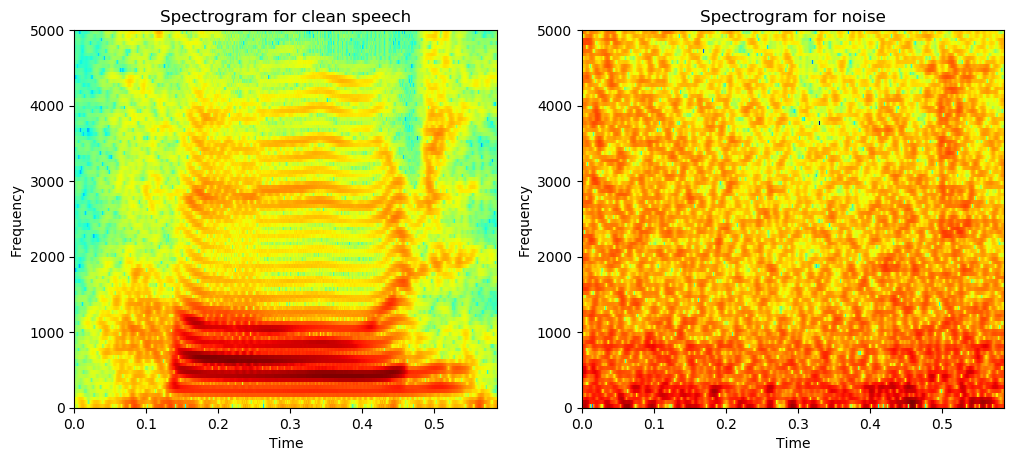

In [13]:
T, nbits, data, nframes, nchannels, sampling_frequency = read_wavfile(origaudioroot+"binary_105_clean.wav")
a = np.asarray(data)
y = np.zeros((nframes, nchannels))
normfactor = 2**(nbits*8-1)
y[:,0] = 1.0*a[0::nchannels]/normfactor
T = 1.0*nframes/sampling_frequency
s = y[:,0]


T, nbits, data, nframes, nchannels, sampling_frequency = read_wavfile(origaudioroot+"binary_105_noise.wav")
a = np.asarray(data)
y = np.zeros((nframes, nchannels))
normfactor = 2**(nbits*8-1)
n = 1.0*a[0::nchannels]/normfactor
snr = 4.0
alpha = np.sqrt(np.sum(s**2)/(np.sum(n**2)*(10**(snr/10))))
n = n*alpha

framesz = 0.02  # with a frame size of 60 milliseconds
hop = 0.001 # 0.0003125      # and hop size of 15 milliseconds.
t = scipy.linspace(0, T, int(T*sampling_frequency), endpoint=False)
cf_cutoff = 5000

S, S_reassigned = tf_reassignment(s, sampling_frequency, framesz, hop, sigma=5)
N, N_reassigned = tf_reassignment(n, sampling_frequency, framesz, hop, sigma=5)

pl.figure(figsize=(12, 5), dpi=100)
pl.subplot(121)
pl.imshow(db(np.abs(S)).T,origin='lower',aspect='auto', extent=[0, T, 0, sampling_frequency], cmap='jet',interpolation='nearest')
pl.xlabel('Time')
pl.ylabel('Frequency')            
pl.ylim((0,cf_cutoff))
pl.title('Spectrogram for clean speech')
pl.subplot(122)
pl.imshow(db(np.abs(N)).T,origin='lower',aspect='auto', extent=[0, T, 0, sampling_frequency], cmap='jet',interpolation='nearest')
pl.xlabel('Time')
pl.ylabel('Frequency')            
pl.ylim((0,cf_cutoff))
pl.title('Spectrogram for noise')

## **Create speech in noise mixture and compute ideal binary mask**

Text(0.5,1,u'Ideal binary mask')

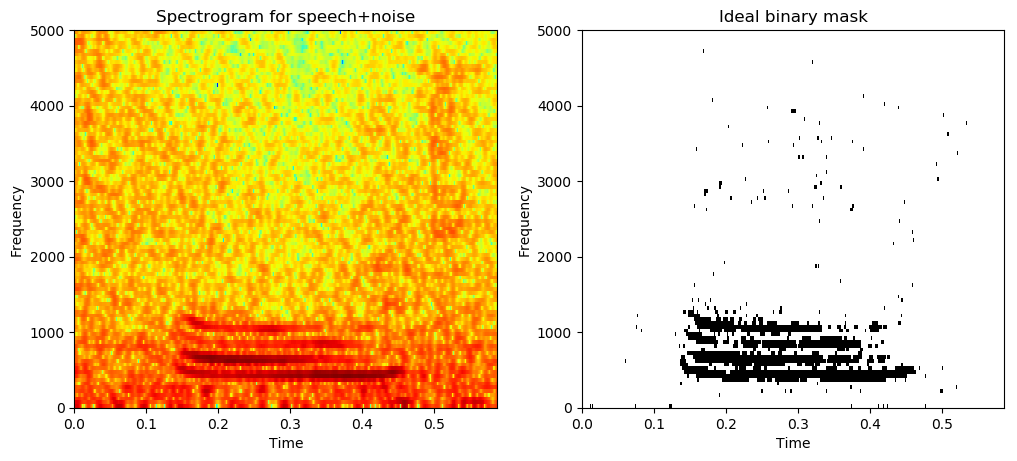

In [14]:
y_orig = s + n
SN, SN_reassigned = tf_reassignment(s+n[:len(s)], sampling_frequency, framesz, hop, sigma=5)

ibm_mask = (np.abs(S)>np.abs(N)*3).astype(int)

pl.figure(figsize=(12, 5), dpi=100)
pl.subplot(121)
pl.imshow(db(np.abs(S+N)).T,origin='lower',aspect='auto', extent=[0, T, 0, sampling_frequency], cmap='jet',interpolation='nearest')
pl.xlabel('Time')
pl.ylabel('Frequency')            
pl.ylim((0,cf_cutoff))
pl.title('Spectrogram for speech+noise')
pl.subplot(122)            
pl.imshow((ibm_mask).T,origin='lower',aspect='auto', extent=[0, T, 0, sampling_frequency], cmap='binary',interpolation='nearest')
pl.xlabel('Time')
pl.ylabel('Frequency')            
pl.ylim((0,cf_cutoff))
pl.title('Ideal binary mask')

## **Ridge detection on clean speech**

(0, 5000)

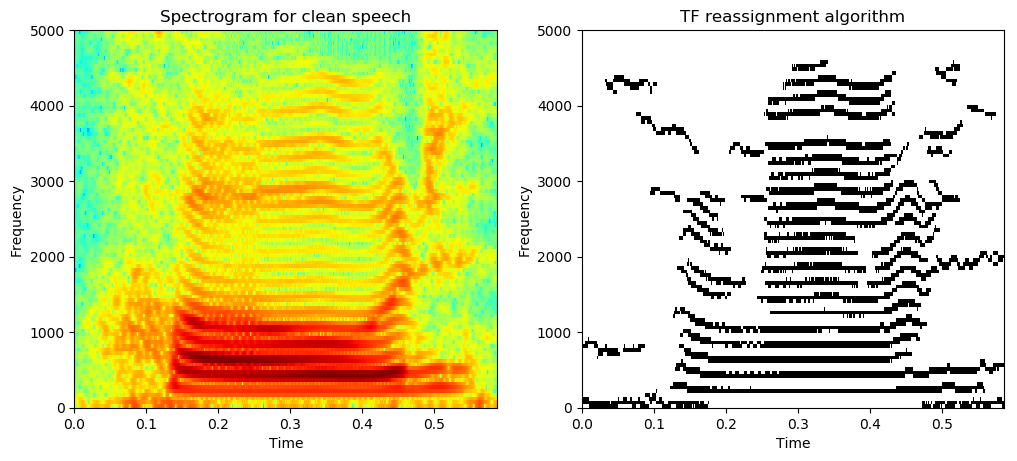

In [15]:
sigma = [4,5,6]

gabor_orig_allsigma, consensus_allsigma = ridge_detection(s, sampling_frequency, framesz, hop,sigma,prct_thr=95, cf_cutoff=cf_cutoff,prune=False,plot=False)
freq = np.linspace(0,sampling_frequency,num=int(sampling_frequency*framesz),endpoint=False)
tspan_fft = np.linspace(0,T,gabor_orig_allsigma[0].shape[0])

final_consensus = np.asarray(consensus_allsigma).sum(axis=0)

pl.figure(figsize=(12, 5), dpi=100)
pl.subplot(121)
pl.imshow(db(np.abs(S)).T,origin='lower',aspect='auto', extent=[0, T, 0, sampling_frequency], cmap='jet',interpolation='nearest')
pl.xlabel('Time')
pl.ylabel('Frequency')            
pl.ylim((0,cf_cutoff))
pl.title('Spectrogram for clean speech')
pl.subplot(122)            
pl.imshow((final_consensus>1).T,origin='lower',aspect='auto', extent=[0, T, 0, cf_cutoff], cmap='binary',interpolation='nearest')
pl.xlabel('Time')
pl.ylabel('Frequency')    
pl.title('TF reassignment algorithm')
# vowel extraction
sigma = [4,5,6]

gabor_orig_allsigma, consensus_allsigma = ridge_detection(s+n, sampling_frequency, framesz, hop,sigma,prct_thr=95, cf_cutoff=cf_cutoff,prune=False,plot=False)
freq = np.linspace(0,sampling_frequency,num=int(sampling_frequency*framesz),endpoint=False)
tspan_fft = np.linspace(0,T,gabor_orig_allsigma[0].shape[0])


final_consensus = np.asarray(consensus_allsigma).sum(axis=0)
pl.ylim((0,cf_cutoff))

## **That seems to work fine, but how about the mixture?**

Text(0.5,1,u'TF reassignment algorithm')

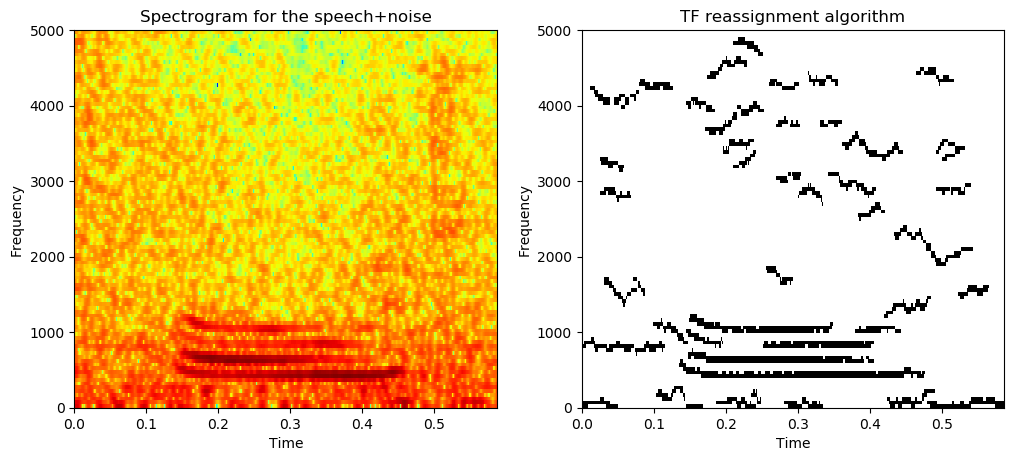

In [16]:
# vowel extraction
sigma = [4,5,6]

gabor_orig_allsigma, consensus_allsigma = ridge_detection(s+n, sampling_frequency, framesz, hop,sigma,prct_thr=95, cf_cutoff=cf_cutoff,prune=False,plot=False)
freq = np.linspace(0,sampling_frequency,num=int(sampling_frequency*framesz),endpoint=False)
tspan_fft = np.linspace(0,T,gabor_orig_allsigma[0].shape[0])

final_consensus = np.asarray(consensus_allsigma).sum(axis=0)

pl.figure(figsize=(12, 5), dpi=100)
pl.subplot(121)
pl.imshow(db(np.abs(SN)).T,origin='lower',aspect='auto', extent=[0, T, 0, sampling_frequency], cmap='jet',interpolation='nearest')
pl.xlabel('Time')
pl.ylabel('Frequency')            
pl.ylim((0,cf_cutoff))
pl.title('Spectrogram for the speech+noise')
pl.subplot(122)            
pl.imshow((final_consensus>1).T,origin='lower',aspect='auto', extent=[0, T, 0, cf_cutoff], cmap='binary',interpolation='nearest')
pl.xlabel('Time')
pl.ylabel('Frequency')            
pl.ylim((0,cf_cutoff))
pl.title('TF reassignment algorithm')

## **The algorithm extracted the main speech components but also lots of noise snippets!**

## **Need to clean up the noise!**

## **Use heuristics to design features for each component**

In [17]:
ridge_mask = final_consensus>1
tlen,flen = ridge_mask.shape
lowfspan=freq[freq<=cf_cutoff]
framesize = 10
n_frames = np.floor(tlen/framesize).astype(int)
pitch_range = np.arange(80,300,1).astype(float)
pitch_est = np.zeros((n_frames,))
pitch_str = np.zeros((n_frames,))
num_harmonics_thresh = 1
pitch_jump_thresh = 10
harm_freq_margin = 0.1
pitch_cand = {}
pitch_cand_str = {}
segments_str = np.zeros(ridge_mask.shape+(n_frames,))
segments_to_keep = np.zeros(ridge_mask.shape)
harmonics_to_keep = np.zeros(ridge_mask.shape)
segments_harm_num = np.zeros(ridge_mask.shape)*np.nan
segments_slope = np.zeros(ridge_mask.shape)*np.nan
segments_harm_dist = np.zeros(ridge_mask.shape)*np.nan
segments_parallelism = np.zeros(ridge_mask.shape)*np.nan

for i_tbin in np.arange(0,n_frames*framesize,framesize):
    CC = measure.regionprops(measure.label(ridge_mask[i_tbin:i_tbin+framesize,:]))
    if len(CC) != 0:
        f_segments = list()
        inds = list()
        slope_segments = list()
        for i in range(len(CC)):
            fmean = freq[CC[i].coords[:,1]].mean()
            if fmean>pitch_range[0]:
                f_segments.append(fmean)
                inds.append(CC[i].coords)  
                x = CC[i].coords[:,0]
                y = CC[i].coords[:,1]
                if len(np.unique(x)) > 1:
                    m,b=np.polyfit(x,y,1)                                
                else:
                    m = 0
                slope_segments.append(m)

        f_segments = np.array(f_segments)
        slope_segments = np.array(slope_segments)
        num_harmonics = f_segments[:,None]/pitch_range[None,:]
        resid = np.abs(num_harmonics - np.round(num_harmonics))
        num_harmonics = np.sum(resid<harm_freq_margin,axis=0)
        pitch_cand_inds = num_harmonics>=num_harmonics_thresh

        segment_cand_str = np.sum(resid[:,pitch_cand_inds]<harm_freq_margin, axis=1)

        for i, ind in enumerate(inds):
            segments_str[ind[:,0]+i_tbin,ind[:,1],(i_tbin/framesize).astype(int)] = segment_cand_str[i]

        if np.sum(pitch_cand_inds) > 0:
            pitch_cand[i_tbin] = pitch_range[pitch_cand_inds]
            pitch_cand_str[i_tbin] = num_harmonics[pitch_cand_inds]
            pitch_est[i_tbin/framesize] = pitch_cand[i_tbin][pitch_cand_str[i_tbin]==pitch_cand_str[i_tbin].max()].max()
            pitch_str[i_tbin/framesize] = pitch_cand_str[i_tbin][pitch_cand[i_tbin]==pitch_est[i_tbin/framesize]]

            for i, ind in enumerate(inds):
                x = ind[:,0]
                y = ind[:,1]
                segments_harm_num[x+i_tbin,y] = np.round(f_segments[i]/pitch_est[i_tbin/framesize])
                segments_slope[x+i_tbin,y] = slope_segments[i]
                segments_harm_dist[x+i_tbin,y] = resid[i, pitch_range==pitch_est[i_tbin/framesize]]
                segments_parallelism[x+i_tbin,y] = (slope_segments[i]-slope_segments.mean())/(slope_segments.std()+np.finfo(np.float32).eps)

            harmf_est = pitch_est[i_tbin/framesize]*np.arange(1,np.floor(cf_cutoff/pitch_est[i_tbin/framesize]))                    
            harmonics_to_keep[i_tbin:i_tbin+framesize, np.round(harmf_est/freq[1]).astype(int)] += 1

            segment_ind_to_keep = resid[:, pitch_range==pitch_est[i_tbin/framesize]]<harm_freq_margin
            inds2, _ = np.nonzero(segment_ind_to_keep)
            if len(inds2) > 0:
                for ind2 in inds2:
                    segments_to_keep[inds[ind2][:,0]+i_tbin,inds[ind2][:,1]] += 1

segments_str_max = np.max(segments_str,axis=2)

segments_combined_feature = np.zeros(ridge_mask.shape)*np.nan
CC = measure.regionprops(measure.label(ridge_mask))
for i, segment in enumerate(CC):
    x = segment.coords[:,0]
    y = segment.coords[:,1]
    segment_x1 = segments_harm_dist[x,y].mean()
    segments_harm_dist[x,y] = segment_x1
    segment_x2 = segments_slope[x,y].std()
    segments_slope[x,y] = segment_x2
    segment_x3 = np.abs(segments_parallelism[x,y]).mean()
    segments_parallelism[x,y] = segment_x3
    segment_x4 = segments_harm_num[x,y].std()
    segments_harm_num[x,y] = segment_x4
    segments_combined_feature[x,y] = (segment_x1<0.1)&(segment_x2<0.1)&(segment_x3<0.9)&(segment_x4<1)

## **Plot each feature for all segments**

Text(0.5,1,u'harmonic number')

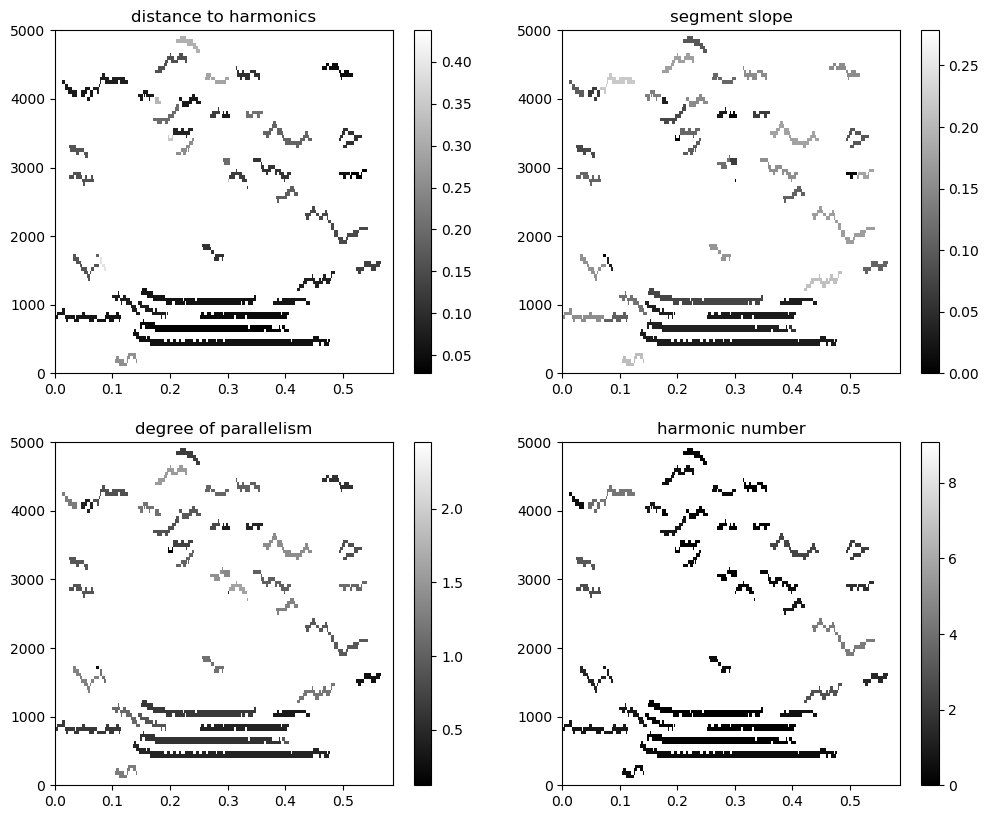

In [18]:
pl.figure(figsize=(12,10), dpi=100)
pl.subplot(2,2,1)
pl.imshow(segments_harm_dist.T, origin='lower',aspect='auto', extent=[0, T, 0, cf_cutoff], cmap='binary_r',interpolation='nearest')
pl.colorbar()
pl.title('distance to harmonics')
pl.subplot(2,2,2)
pl.imshow(segments_slope.T, origin='lower',aspect='auto', extent=[0, T, 0, cf_cutoff], cmap='binary_r',interpolation='nearest')
pl.colorbar()
pl.title('segment slope')
pl.subplot(2,2,3)
pl.imshow(segments_parallelism.T, origin='lower',aspect='auto', extent=[0, T, 0, cf_cutoff], cmap='binary_r',interpolation='nearest')
pl.colorbar()
pl.title('degree of parallelism')
pl.subplot(2,2,4)
pl.imshow(segments_harm_num.T, origin='lower',aspect='auto', extent=[0, T, 0, cf_cutoff], cmap='binary_r',interpolation='nearest')
pl.colorbar()
pl.title('harmonic number')

## **Each of these features picks up different subsets of noise components**

## ** Now when they are combined using a simple logical AND:**

Text(0.5,1,u'Ideal binary mask')

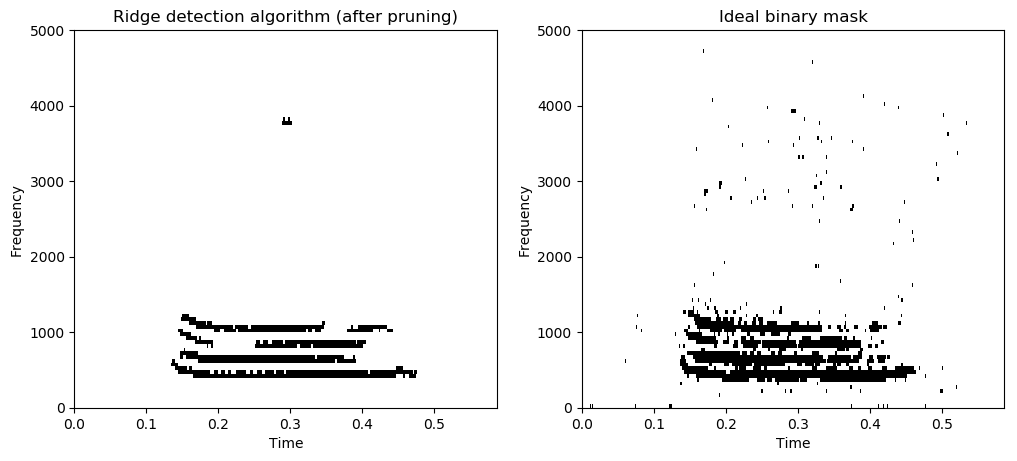

In [19]:
segments_to_keep_pruned = np.zeros(ridge_mask.shape)   
segments_to_keep_pruned[segments_combined_feature==1] = 1

half_vowel_mask = np.concatenate( ((segments_to_keep_pruned), np.zeros( (len(tspan_fft), int(len(freq)/2)-final_consensus.shape[1])) ), axis=1)
half_speech_mask = half_vowel_mask
speech_mask = np.concatenate((half_speech_mask,np.fliplr(half_speech_mask)),axis=1)
gabor_enh = speech_mask*gabor_orig_allsigma[-2]

pl.figure(figsize=(12,5), dpi=100)
pl.subplot(121)
pl.imshow(speech_mask.T,origin='lower',aspect='auto', 
          extent=[0, T, 0, sampling_frequency], interpolation='nearest', cmap='binary')
pl.ylim((0, sampling_frequency/2))
pl.xlabel('Time')
pl.ylabel('Frequency')
pl.ylim((0,cf_cutoff))
pl.title('Ridge detection algorithm (after pruning)')
pl.subplot(122)
pl.imshow((ibm_mask).T,origin='lower',aspect='auto', extent=[0, T, 0, sampling_frequency], cmap='binary',interpolation='nearest')
pl.xlabel('Time')
pl.ylabel('Frequency')            
pl.ylim((0,cf_cutoff))
pl.title('Ideal binary mask')          



Text(0.5,1,u'Speech recovered by ideal binary mask')

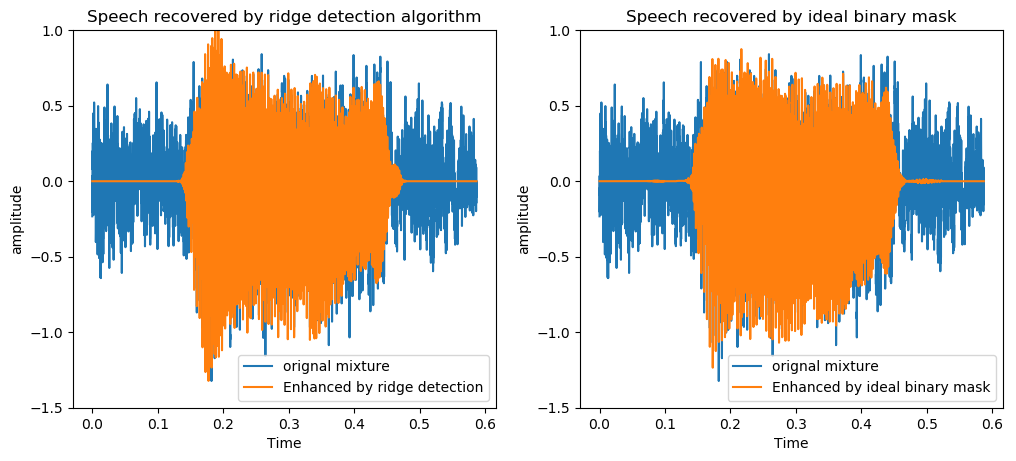

In [20]:
y_enh = istft(gabor_enh, sampling_frequency, T, hop)
y_enh = y_enh/rms(y_enh)*rms(y_orig)

y_ibm = istft(ibm_mask*gabor_orig_allsigma[-2], sampling_frequency, T, hop)
y_ibm = y_ibm/rms(y_ibm)*rms(y_orig)
#           
pl.figure(figsize=(12,5), dpi=100)
pl.subplot(121)
pl.plot(t,y_orig)
pl.plot(t,y_enh)
pl.xlabel('Time')
pl.ylabel('amplitude')
pl.ylim((-1.5, 1))
pl.legend(['orignal mixture','Enhanced by ridge detection'])
pl.title('Speech recovered by ridge detection algorithm')
pl.subplot(122)
pl.plot(t,y_orig)
pl.plot(t,y_ibm)
pl.xlabel('Time')
pl.ylabel('amplitude')
pl.ylim((-1.5, 1))
pl.legend(['orignal mixture','Enhanced by ideal binary mask'])
pl.title('Speech recovered by ideal binary mask')

In [17]:
segment_x1_allrep = list()
segment_x2_allrep = list()
segment_x3_allrep = list()
segment_x4_allrep = list()
segment_x5_allrep = list()

nrep = 1000
for rep in range(nrep):
    # print '#'+str(rep+1) + ' of ' + str(nrep) + ' repetitions'
    nframes = 10000
    sampling_frequency = 16000.0
    noise = np.random.normal(loc=0, scale=1, size=(nframes,))
    Noise = np.fft.rfft(noise)
    f = np.fft.fftfreq(nframes, d=1./sampling_frequency)[:len(Noise)]
    f[-1]=np.abs(f[-1])
    alpha = 0.09
    gain = np.ones_like(f)
    gain[1:] = np.abs((f[1:]**(-alpha)))
    gain[gain>1] = 1
    Noise_pink = Noise * gain
    noise_pink = np.fft.irfft(Noise_pink)    
    n = noise_pink
                
    #### STFT analysis  ####
    
    T = nframes/sampling_frequency
    framesz = 0.02  # with a frame size of 60 milliseconds
    hop = 0.001 # 0.0003125      # and hop size of 15 milliseconds.
    t = scipy.linspace(0, T, nframes, endpoint=False)
    cf_cutoff = 5000
    
    N, N_reassigned = tf_reassignment(n, sampling_frequency, framesz, hop, sigma=5)
    
    
    # vowel extraction
    sigma = [4,5,6]
    
    gabor_orig_allsigma, consensus_allsigma = ridge_detection(n, sampling_frequency, framesz, hop,sigma,prct_thr=95, cf_cutoff=cf_cutoff,prune=False,plot=False)
    freq = np.linspace(0,sampling_frequency,num=int(sampling_frequency*framesz),endpoint=False)
    tspan_fft = np.linspace(0,T,gabor_orig_allsigma[0].shape[0])
    
    final_consensus = np.asarray(consensus_allsigma).sum(axis=0)
    
    ridge_mask = final_consensus>1
    tlen,flen = ridge_mask.shape
    
    lowfspan=freq[freq<=cf_cutoff]
    framesize = 10
    n_frames = np.floor(tlen/framesize).astype(int)
    pitch_range = np.arange(80,300,1).astype(float)
    pitch_est = np.zeros((n_frames,))
    pitch_str = np.zeros((n_frames,))
    num_harmonics_thresh = 1
    pitch_jump_thresh = 10
    harm_freq_margin = 0.1
    pitch_cand = {}
    pitch_cand_str = {}
    segments_str = np.zeros(ridge_mask.shape+(n_frames,))
    segments_to_keep = np.zeros(ridge_mask.shape)
    harmonics_to_keep = np.zeros(ridge_mask.shape)
    segments_harm_num = np.zeros(ridge_mask.shape)*np.nan
    segments_slope = np.zeros(ridge_mask.shape)*np.nan
    segments_harm_dist = np.zeros(ridge_mask.shape)*np.nan
    segments_parallelism = np.zeros(ridge_mask.shape)*np.nan
    
    for i_tbin in np.arange(0,n_frames*framesize,framesize):
        CC = measure.regionprops(measure.label(ridge_mask[i_tbin:i_tbin+framesize,:]))
        if len(CC) != 0:
            f_segments = list()
            inds = list()
            slope_segments = list()
            for i in range(len(CC)):
                fmean = freq[CC[i].coords[:,1]].mean()
                if fmean>pitch_range[0]:
                    f_segments.append(fmean)
                    inds.append(CC[i].coords)  
                    x = CC[i].coords[:,0]
                    y = CC[i].coords[:,1]
                    if len(np.unique(x)) > 1:
                        m,b=np.polyfit(x,y,1)
                    else:
                        m = 0
                    slope_segments.append(m)
                    
                        
            f_segments = np.array(f_segments)
            slope_segments = np.array(slope_segments)
            num_harmonics = f_segments[:,None]/pitch_range[None,:]
            resid = np.abs(num_harmonics - np.round(num_harmonics))
            num_harmonics = np.sum(resid<harm_freq_margin,axis=0)
            pitch_cand_inds = num_harmonics>=num_harmonics_thresh
            
            segment_cand_str = np.sum(resid[:,pitch_cand_inds]<harm_freq_margin, axis=1)
            
            for i, ind in enumerate(inds):
                segments_str[ind[:,0]+i_tbin,ind[:,1],(i_tbin/framesize).astype(int)] = segment_cand_str[i]
            
            if np.sum(pitch_cand_inds) > 0:
                pitch_cand[i_tbin] = pitch_range[pitch_cand_inds]
                pitch_cand_str[i_tbin] = num_harmonics[pitch_cand_inds]
                pitch_est[i_tbin/framesize] = pitch_cand[i_tbin][pitch_cand_str[i_tbin]==pitch_cand_str[i_tbin].max()].max()
                pitch_str[i_tbin/framesize] = pitch_cand_str[i_tbin][pitch_cand[i_tbin]==pitch_est[i_tbin/framesize]]
                
                for i, ind in enumerate(inds):
                    x = ind[:,0]
                    y = ind[:,1]
                    segments_harm_num[x+i_tbin,y] = np.round(f_segments[i]/pitch_est[i_tbin/framesize])
                    segments_slope[x+i_tbin,y] = slope_segments[i]
                    segments_harm_dist[x+i_tbin,y] = resid[i, pitch_range==pitch_est[i_tbin/framesize]]
                    segments_parallelism[x+i_tbin,y] = (slope_segments[i]-slope_segments.mean())/(slope_segments.std()+np.finfo(np.float32).eps)
                    
                harmf_est = pitch_est[i_tbin/framesize]*np.arange(1,np.floor(cf_cutoff/pitch_est[i_tbin/framesize]))                    
                harmonics_to_keep[i_tbin:i_tbin+framesize, np.round(harmf_est/freq[1]).astype(int)] += 1
                                              
                        
    segments_str_max = np.max(segments_str,axis=2)
    
    segments_combined_feature = np.zeros(ridge_mask.shape)*np.nan
    temp = np.zeros(ridge_mask.shape)
    CC = measure.regionprops(measure.label(ridge_mask))
    segment_x1 = np.zeros((len(CC),))
    segment_x2 = np.zeros((len(CC),))
    segment_x3 = np.zeros((len(CC),))
    segment_x4 = np.zeros((len(CC),))
    segment_x5 = np.zeros((len(CC),))
    for i, segment in enumerate(CC):
        x = segment.coords[:,0]
        y = segment.coords[:,1]
        segment_x1[i] = segments_harm_dist[x,y].mean()
        segment_x2[i] = segments_harm_dist[x,y].std()
        segment_x3[i] = segments_slope[x,y].std()
        segment_x4[i] = np.abs(segments_parallelism[x,y]).mean()
        segment_x5[i] = segments_harm_num[x,y].std()
        
        segments_combined_feature[x,y] = (segment_x1[i]<0.1)&(segment_x1[i]<0.1)&(segment_x3[i]<1.5)&(segment_x4[i]<1.2)&(segment_x5[i]<1)
        if np.isnan(segment_x1[i]):
            temp[x,y] = 2
        else:
            temp[x,y] = 1
    
    segment_x1_allrep = segment_x1_allrep + list(segment_x1)
    segment_x2_allrep = segment_x2_allrep + list(segment_x2)
    segment_x3_allrep = segment_x3_allrep + list(segment_x3)
    segment_x4_allrep = segment_x4_allrep + list(segment_x4)
    segment_x5_allrep = segment_x5_allrep + list(segment_x5)

segment_x1_allrep = np.asarray(segment_x1_allrep)
segment_x2_allrep = np.asarray(segment_x2_allrep)
segment_x3_allrep = np.asarray(segment_x3_allrep)
segment_x4_allrep = np.asarray(segment_x4_allrep)
segment_x5_allrep = np.asarray(segment_x5_allrep)
segment_x1_allrep = segment_x1_allrep[~np.isnan(segment_x1_allrep)]
segment_x2_allrep = segment_x2_allrep[~np.isnan(segment_x2_allrep)]
segment_x3_allrep = segment_x3_allrep[~np.isnan(segment_x3_allrep)]
segment_x4_allrep = segment_x4_allrep[~np.isnan(segment_x4_allrep)]
segment_x5_allrep = segment_x5_allrep[~np.isnan(segment_x5_allrep)]

Text(0.5,1,u'harmonic number histogram')

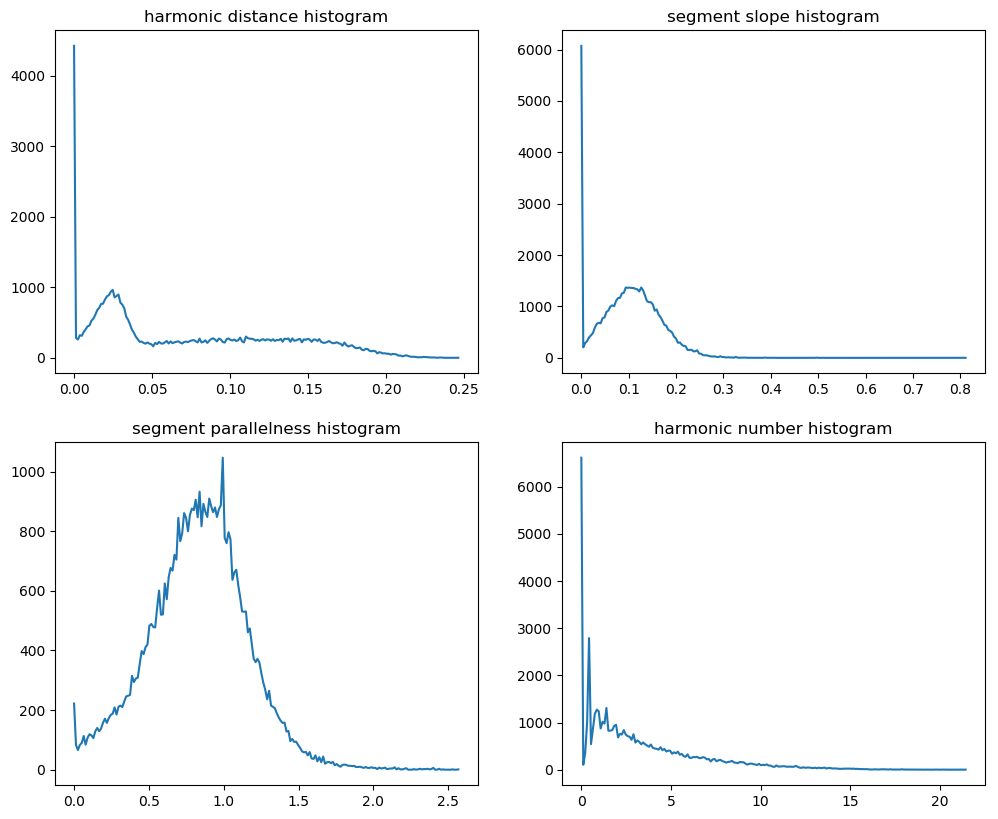

In [19]:
pl.figure(figsize=(12,10), dpi=100)
pl.subplot(221)
counts, bins = pl.histogram(segment_x2_allrep, bins=200)
pl.plot(bins[:-1], counts)
pl.title('harmonic distance histogram')
pl.subplot(222)
counts, bins = pl.histogram(segment_x3_allrep, bins=200)
pl.plot(bins[:-1], counts)
pl.title('segment slope histogram')
pl.subplot(223)
counts, bins = pl.histogram(segment_x4_allrep, bins=200)
pl.plot(bins[:-1], counts)
pl.title('segment parallelness histogram')
pl.subplot(224)
counts, bins = pl.histogram(segment_x5_allrep, bins=200)
pl.plot(bins[:-1], counts)
pl.title('harmonic number histogram')